In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import scipy
from tqdm import tqdm
import seaborn as sns
from utils import *
colors = sns.palettes.color_palette("muted")
sns.set_style("darkgrid")
sns.set_context("paper")

### **Question 1.1**

In [2]:
data = pd.read_excel("./Problem_C_Data_Wordle.xlsx")
data.set_index("Date",inplace=True)
data.sort_index(inplace=True)
data.head()

,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),Hard Ratio
Date,,,,,,,,,,,,
2022-01-07,202,slump,80630,1362,1,3,23,39,24,9,1,0.016892
2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2,0.017369
2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4,0.020912
2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2,0.020927
2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1,0.019606


Text(0, 0.5, 'Number of reported results')

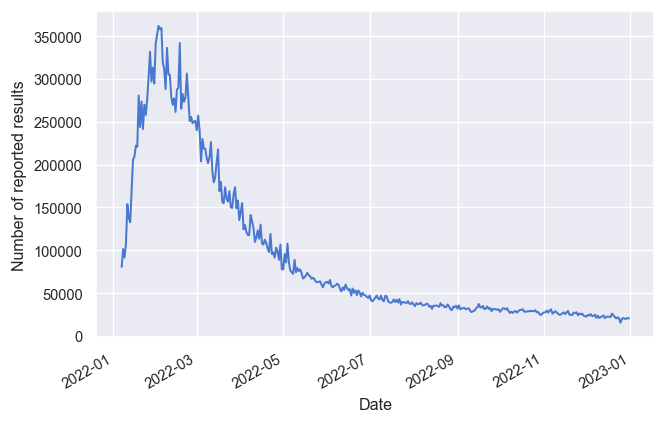

In [3]:
fig = plt.figure(figsize=(6,4),dpi=120)
data.loc["2022-01-01":,"Number of  reported results"].plot(color=colors[0])
plt.ylabel("Number of reported results")

**(1) Design of the trend model**

We use the **breakpoint detection** to split the time series into serveral parts.
* Find two optimal breakpoints $bp_1,bp_2$.
* Use different assumptions to model different parts.

NameError: name 'labels' is not defined

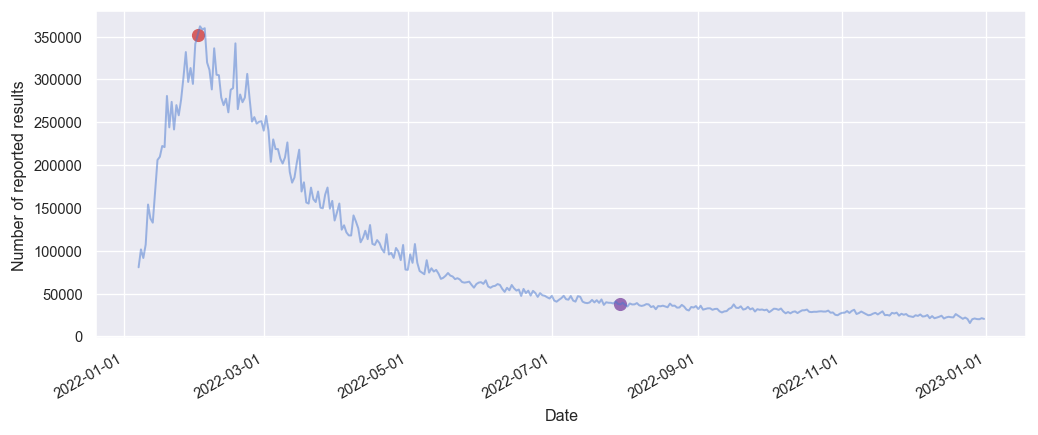

In [4]:
# breakpoint detection
bp_1 = breakpoint_detection_regression(data=data["Number of  reported results"],iters=30)
bp_2 = breakpoint_detection_regression(data=data["Number of  reported results"],left=bp_1,iters=30)
fig,ax = plt.subplots(figsize=(10,4),dpi=120)
s = data.loc["2022-01-01":,"Number of  reported results"]
ax.set_ylabel("Number of reported results")
ax.scatter(data.index[bp_1],data.iloc[bp_1,2],color=colors[3],s=50,label="Break Point 1")
ax.scatter(data.index[bp_2],data.iloc[bp_2,2],color=colors[4],s=50,label="Break Point 2")
s.plot(color=colors[0],alpha=0.5,ax=ax)
xticks, labels_2 = ax.get_xticks(), ax.get_xticklabels()
ax.set_xticks(xticks)
ax.set_xticklabels(labels,rotation=0)
ax.legend()

Now, we split the series into **four parts**:
* Part I: **Assumption of fast rising stage**, can be expressed by the following linear model:
$$
y_t = \beta_1\cdot t + \beta_0 + \varepsilon_1,\quad \text{i.e.}\quad y_t \sim N(\beta_1\cdot t + \beta_0,\sigma_1^2)
$$
* Part II: **Assumption of fast exponential decay stage**, can be expressed by the following model:  
    Assume the decay rate $dy_t/dt$ satisfies the following differential equation:
    $$
    \frac{dy_t}{dt} = -c_1\cdot\beta_2^{(decay)}\cdot e^{-\beta_2^{(decay)} t}
    $$
    Then $y_t$ has the following expression:
    $$
    y_t = y_0 + c_1e^{-\beta_2^{(decay)} t} + \varepsilon_3, \quad \text{i.e.}\quad y_t \sim N\left(y_0 + c_1e^{-\beta_2^{(decay)} t} ,\sigma_3^2  \right)
    $$
* Part II: **Assumption of slow exponential decay stage**, can be expressed by the following model:  
    Assume the decay rate $dy_t/dt$ satisfies the following differential equation:
    $$
    \frac{dy_t}{dt} = \beta_3^{(decay)}\cdot y_t\cdot(1 - \frac{y}{y_1})
    $$
    Then $y_t$ has the following expression:
    $$
    y_t = \frac{y_1}{1 + e^{c_2-\beta_3^{(decay)}t}} + \varepsilon_3, \quad \text{i.e.}\quad y_t \sim N\left(\frac{y_1}{1 + e^{c_2-\beta_3^{(decay)}t}},\sigma_3^2  \right)
    $$
* Part IV (Unknown phase): Assume that **there is a stable number of reported results** #\mu# when $t$ is large enough. Then:
$$
y_t = \mu + \varepsilon_4,\quad \text{i.e.}\quad y_t\sim N(\mu,\sigma_4^2)
$$

In [5]:
# part I
def part1_curve(t, beta_0, beta_1):
    return beta_0 + beta_1 * t
ydata = data.iloc[0:bp_1,2].values / 1e4
opt_param, cov_param, lower, upper = curve_fit_estimate(ydata,part1_curve)
part1_pred = curve_fit_predict(len(ydata),part1_curve,opt_param,cov_param) * 1e4
print("Part I Model Coef:")
print("beta_0: {:.4f}, beta_1: {:.4f}".format(*opt_param))
print("95% lower bound beta_0: {:.4f}, beta_1: {:.4f}".format(*lower))
print("95% upper bound beta_0: {:.4f}, beta_1: {:.4f}".format(*upper))
print("="*60)

# Part II
def part2_curve(t, y0, c, beta):
    return y0 + c*np.exp(-beta*t)
ydata = data.iloc[bp_1:bp_2,2].values / 1e3
opt_param, cov_param, lower, upper = curve_fit_estimate(ydata,part2_curve)
part2_pred = curve_fit_predict(len(ydata),part2_curve,opt_param,cov_param,directions=[True,True,False]) * 1e3
print("Part II Model Coef:")
print("y_0 : {:.4f}, c_1: {:.4f}, beta_2: {:.4f}".format(*opt_param))
print("95% lower bound y_0 : {:.4f}, c_1: {:.4f}, beta_2: {:.4f}".format(*lower))
print("95% upper bound y_0 : {:.4f}, c_1: {:.4f}, beta_2: {:.4f}".format(*upper))
print("="*60)

# Part II
def part3_curve(t, y1, c, beta):
    return y1 / (1 + np.exp(c + beta*t))
ydata = data.iloc[bp_2:,2].values / 1e4
opt_param, cov_param, lower, upper = curve_fit_estimate(ydata,part3_curve)
part3_pred = curve_fit_predict(len(ydata),part3_curve,opt_param,cov_param,directions=[True,False,False]) * 1e4
print("Part III Model Coef:")
print("y_1 : {:.4f}, c_2: {:.4f}, beta_3: {:.4f}".format(*opt_param))
print("95% lower bound y_1 : {:.4f}, c_2: {:.4f}, beta_3: {:.4f}".format(*lower))
print("95% upper bound y_1 : {:.4f}, c_2: {:.4f}, beta_3: {:.4f}".format(*upper))
print("="*60)

Part I Model Coef:
beta_0: 8.6915, beta_1: 104.1459
95% lower bound beta_0: 6.8340, beta_1: 91.6514
95% upper bound beta_0: 10.5489, beta_1: 116.6404
Part II Model Coef:
y_0 : 17.4590, c_1: 349.7751, beta_2: 1.6962
95% lower bound y_0 : 10.9417, c_1: 342.7969, beta_2: 1.5919
95% upper bound y_0 : 23.9763, c_1: 356.7533, beta_2: 1.8004
Part III Model Coef:
y_1 : 4.8167, c_2: -1.1701, beta_3: 0.9352
95% lower bound y_1 : 3.7938, c_2: -1.9884, beta_3: 0.6131
95% upper bound y_1 : 5.8395, c_2: -0.3518, beta_3: 1.2572


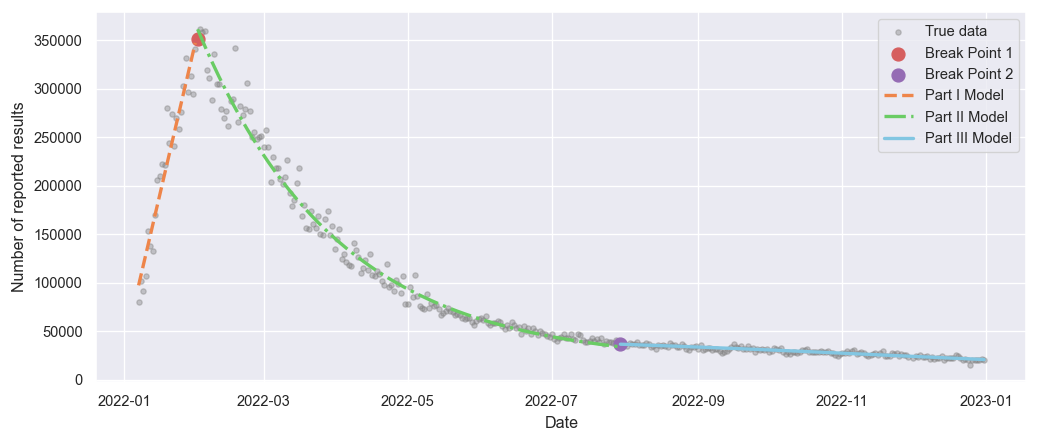

In [6]:
fig = plt.figure(figsize=(10,4),dpi=120)
plt.scatter(data.index,data["Number of  reported results"],color="grey",alpha=0.4,s=10,label="True data")
plt.ylabel("Number of reported results")
plt.scatter(data.index[bp_1],data.iloc[bp_1,2],color=colors[3],s=60,label="Break Point 1")
plt.scatter(data.index[bp_2],data.iloc[bp_2,2],color=colors[4],s=60,label="Break Point 2")
plt.plot(data.index[0:bp_1],part1_pred.center,color=colors[1],lw=2,ls="--",label="Part I Model")
plt.plot(data.index[bp_1:bp_2],part2_pred.center,color=colors[2],lw=2,ls="-.",label="Part II Model")
plt.plot(data.index[bp_2:],part3_pred.center,color=colors[9],lw=2,label="Part III Model")
plt.xlabel("Date")
plt.legend()

**Predict the number of reported results on March 1, 2023**

Prediction results of point estimation: 14613.9458
95% confidence interval of prediction: [11132.9786, 18094.9131]


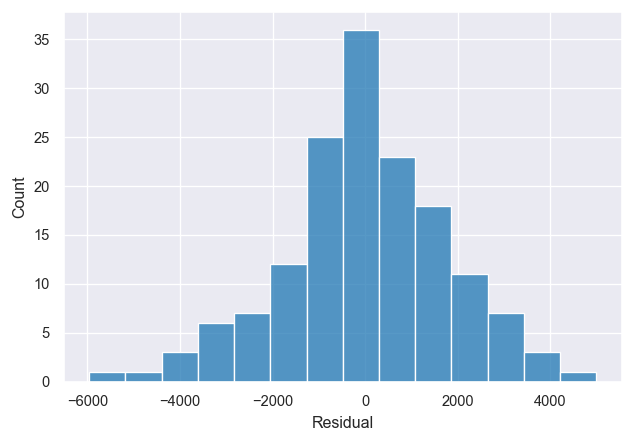

In [7]:
# fit the curve
def part3_curve(t, y1, c, beta):
    return y1 / (1 + np.exp(c + beta*t))
ydata = data.iloc[bp_2:,2].values / 1e4
opt_param, cov_param, lower, upper = curve_fit_estimate(ydata,part3_curve)
part3_pred = curve_fit_predict(len(ydata) + 60,part3_curve,opt_param,cov_param,directions=[True,False,False]) * 1e4
# calculate residual
residuals = ydata*1e4 - part3_pred.center[:len(ydata)]
fig = plt.figure(figsize=(6,4),dpi=120)
sns.histplot(residuals)
plt.xlabel("Residual")
# standard deviation of residual
residuals_std = residuals.std()
interval = [part3_pred.center.values[-1] - 1.96*residuals_std,
            part3_pred.center.values[-1] + 1.96*residuals_std]
print("Prediction results of point estimation: %.4f"%(part3_pred.center.values[-1]))
print("95% confidence interval of prediction: [{:.4f}, {:.4f}]".format(*interval))

**(2) Design of the word attributions**

Fetch the word frequency of 5-letters words

In [8]:
words_freq = pd.read_csv("./unigram_freq.csv")
words_freq["length"] = words_freq.word.apply(lambda x : len(str(x)))
words_freq = words_freq.loc[words_freq.length == 5].reset_index(drop=True)
words_freq.head()

,word,count,length
0,about,1226734006,5
1,other,978481319,5
2,which,810514085,5
3,their,782849411,5
4,there,701170205,5


Load valid Wordle words, and check whether we have the corresponding frequency data.

In [9]:
valid_words = pd.read_csv("./valid_wordle.txt",header=None)[0]

In [10]:
missing_words = []
valid_words_freq = {}
words_set = {words_freq["word"][i]:words_freq["count"][i] for i in range(len(words_freq))}
for word in valid_words:
    if word not in words_set:
        missing_words.append(word)
    else:
        valid_words_freq[word] = words_set[word]

In [11]:
# count for valid words frequency
valid_words_freq = pd.Series(valid_words_freq)
valid_words_freq.sort_values(ascending=False,inplace=True)
valid_words_freq = valid_words_freq / valid_words_freq.sum() # rescale
# fill the missing words frequency
missing_words_freq = pd.Series(index=missing_words,data=valid_words_freq.quantile(0.01))
# concat together
valid_words_freq = pd.concat([valid_words_freq,missing_words_freq])
valid_words_freq = valid_words_freq / valid_words_freq.sum() # rescale
# save file
valid_words_freq.to_csv("valid_words_freq.csv")

**(2.1) Basic Words Attributes**

Count the probability of each letter appearing at each position ($i=1,2,\cdots,5$) in all the **valid Wordle words**

In [12]:
def letter_frequency_position(valid_words):
    letters_freq = pd.DataFrame(data=0,index=[chr(i) for i in range(65,65+26)],columns=[1,2,3,4,5])
    for word in valid_words:
        for pos,s in enumerate(word):
            letters_freq.loc[s.upper(),pos+1] += 1
    letters_freq = letters_freq / np.sum(letters_freq.values,axis=0,keepdims=True)
    return letters_freq

In [13]:
letters_freq_pos = letter_frequency_position(valid_words)
letters_freq_pos.head()

,1,2,3,4,5
A,0.056815,0.174453,0.095282,0.082794,0.052421
B,0.070074,0.006244,0.025825,0.018733,0.004548
C,0.071076,0.013568,0.030219,0.031684,0.009790
D,0.052806,0.006475,0.030065,0.036309,0.063444
E,0.023358,0.125501,0.067993,0.179386,0.117330


Now, for a given Wordle puzzle word $W=(w_1,\cdots,w_5)$, we can use the above frequency data as 5 features.
$$
\left[f_{w_1}^{(1)},f_{w_2}^{(2)},\cdots,f_{w_5}^{(5)}\right]
$$

In [14]:
def build_letter_freq_pos_feat(word : str, letters_freq_pos):
    """
    build letter frequency position features.
    """
    assert len(word) == 5
    feat = []
    for i,s in enumerate(word):
        feat.append(letters_freq_pos.loc[s.upper(),i+1])
    return feat

In [15]:
# for example
print("letter frequency position featurns of apple: \
[{:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}]".format(*build_letter_freq_pos_feat("apple",letters_freq_pos)))
print("letter frequency position featurns of grace: \
[{:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}]".format(*build_letter_freq_pos_feat("grace",letters_freq_pos)))

letter frequency position featurns of apple: [0.057, 0.018, 0.028, 0.059, 0.117]
letter frequency position featurns of grace: [0.049, 0.072, 0.095, 0.032, 0.117]


The **above probabilities are aggregated in the position dimension**. We can **also aggregate in the letter dimension** to get the distribution of each letter in different positions. 

In [16]:
def letter_frequency_letter(valid_words):
    letters_freq = pd.DataFrame(data=0,index=[chr(i) for i in range(65,65+26)],columns=[1,2,3,4,5])
    for word in valid_words:
        for pos,s in enumerate(word):
            letters_freq.loc[s.upper(),pos+1] += 1
    letters_freq = letters_freq / np.sum(letters_freq.values,axis=1,keepdims=True)
    return letters_freq

In [17]:
letters_freq_let = letter_frequency_letter(valid_words)
letters_freq_let.head()

,1,2,3,4,5
A,0.123038,0.377796,0.206344,0.179299,0.113523
B,0.558697,0.049785,0.205900,0.149355,0.036263
C,0.454635,0.086785,0.193294,0.202663,0.062623
D,0.279250,0.034244,0.158989,0.192010,0.335508
E,0.045482,0.244371,0.132393,0.349295,0.228460


In [18]:
def build_letter_freq_let_feat(word : str, letters_freq_let):
    """
    build letter frequency position features.
    """
    assert len(word) == 5
    feat = []
    for i,s in enumerate(word):
        feat.append(letters_freq_let.loc[s.upper(),i+1])
    return feat

In [19]:
# for example
print("letters frequency letter featurns of apple: \
[{:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}]".format(*build_letter_freq_let_feat("apple",letters_freq_let)))
print("letters frequency letter featurns of grace: \
[{:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}]".format(*build_letter_freq_let_feat("grace",letters_freq_let)))

letters frequency letter featurns of apple: [0.123, 0.114, 0.180, 0.229, 0.228]
letters frequency letter featurns of grace: [0.388, 0.226, 0.206, 0.203, 0.228]


Gini index $G$ can be used to define **the degree of variation of the letter distribution of a word**:
* The more letters a word contains (up to 5). The greater the degree of variation, the greater the Gini index $G$
* The less letters a word contains, that is, more repeated letters. The smaller the degree of variation, the smaller the Gini index $G$

$$
G = 1 - \sum_{i=1}^{K} p_i^2
$$
in which, $K$ is the number of different letters in a word. Notice that:
$$
0 < G \leq 1 - \sum_{i=1}^{5}(1/5)^2 = 0.8
$$

In [20]:
def build_letter_gini(word : str):
    cnts = Counter(word)
    prob = {k:v / 5 for k,v in cnts.items()}
    gini = 1 - sum([p**2 for p in prob.values()])
    return gini

In [21]:
# for example
print("Gini index of apple: %.4f"%(build_letter_gini("apple")))
print("Gini index of grace: %.4f"%(build_letter_gini("grace")))

Gini index of apple: 0.7200
Gini index of grace: 0.8000


The appearance of **continuous letters in the word** may help people to guess, and set a feature $f_c$ to judge whether there are continuous characters.

$$
f_c = \left\{
    \begin{array}{ll}
    1, & \text{Continuous letters appear} \\
    0, & \text{Ohters}
    \end{array}
\right.
$$

In [22]:
def build_letter_continuous(word : str):
    """
    Judge whether the word has the continuous letters.
    """
    for i in range(4):
        if word[i] == word[i+1]:
            return 1
    return 0

In [23]:
# for example
print("Continuous letters appear in apple: %s"%(build_letter_continuous("apple")))
print("Continuous letters appear in grace: %s"%(build_letter_continuous("grace")))

Continuous letters appear in apple: 1
Continuous letters appear in grace: 0


**(2.2) Wordle Game Attributes**

The basic idea is to **use entropy to measure our current uncertainty**

For a given word $W$, assuming that there are total $N$ answers and $M$ valid guessing words in Wordle, the guess strategy for a human may follow as:
* At the beginning, **we have no information about the guessed words** $W$. The uncertainty of the system is the largest, and the entropy is:
    $$
    H = \log_2 N 
    $$
* In the **first round**, for any guess $A_1$, players will receive a feedback containing an array of five elements (each has 3 color states), which **provides us with information to reduce the uncertainty of the system**. 
  * In short, the feasible state space of the system will be reduced from $N$ to $N_1$
    $$
    N \to N_1(A_1,W),\quad N > N_1(A_1,W)
    $$
    Notice that $N_1$ is relative to guess $A_1$ and target word $W$.
  * Therefore, we can imitate the **decision tree** and **define the gain** $\text{Gain}_1(A_1,W)$ brought by guess $A_1$ as **the reduction of system uncertainty**:
    $$
    \text{Gain}_1(A_1,W) = \log_2 N - \log_2 N_1(A_1,W)
    $$
  * If we **try each word in the valid words** in turn, we can define the possible **average gain** $\text{Gain}_1(W)$ of the system for the word $W$ in the first round:
    $$
    \text{Gain}_1(W) = \sum_{A_1\in \text{valid words}} w_{A_1}\cdot \text{Gain}_1(A_1,W)
    $$
    in which, weight $w_{A_1}$ represents **the possibility that players choose** $A_1$ **from the valid words to guess** $W$, which can be defined as word frequency.
  * Notice that $\text{Gain}(W)$ various with $W$:
    * For a difficult word $W$, the **possible gain from trying all guesses** $\text{Gain}_1(W)$ is also small, and more guesses are needed to obtain more information.
    * $\text{Gain}_1(W)$ **can be used as an attribute to describe the difficulty of the word**.
* The **above process can be deduced to the next round**. We search all possible guesses in the subset in turn, and then calculate the average gain brought by these guesses. Therefore, we can define such as:
  $$
  \text{Gain}_2(W),\text{Gain}_3(W),\cdots
  $$

There are two remaining problems in the above process:
* Is it suitable to **assume that all valid words can be used as answers**, or **is there only 2315 words in the real answer set**, as said on the Internet?
$$
N = M?
$$
* Whether it is **assumed that the target word** $W$ **of Wordle every day are selected randomly from the answer set**, or whether it is **assumed that the choice of the answer is related to the word frequency**. This will change the calculation of entropy for system.
$$
H = -\sum_{i} \frac{1}{N}\log_2 \frac{1}{N} = \log_2 N \quad \text{or} \quad H = -\sum_{i} f_{W_i}\log_2 f_{W_i}
$$

--------

In [26]:
# create Wordle score table
# pivot_table = create_wordle_score_table(valid_words,valid_words)
# pivot_table.columns.name = "Guess"
# pivot_table.index.name = "Target"
# pivot_table.to_parquet("./wordle_score_pivot.gzip",compression="gzip") # save table

If we have fetch the data we need, we can load from directory.

In [27]:
pivot_wordle_score = pd.read_parquet("./wordle_score_pivot.gzip")

In [28]:
# filter answer state space
ans_words = pd.read_csv("./ans_wordle.csv")["target"]
pivot_wordle_score = pivot_wordle_score.loc[ans_words]

In [24]:
def build_word_features(words : list, n_jobs : int=20):
    # parallel acceleration
    def helper_func(target : str):
        feat = []
        # # wird frequency
        # feat.append(valid_words_freq[target])
        # letter frequency position feaures
        feat.extend(build_letter_freq_pos_feat(target,letters_freq_pos))
        # letter frequency letter feaures
        feat.extend(build_letter_freq_let_feat(target,letters_freq_let))
        # target gini
        feat.append(build_letter_gini(target))
        # continuous
        feat.append(build_letter_continuous(target))
        # gain round 1
        feat.append(build_gain_recur(target,pivot_wordle_score,valid_words_freq,rounds=1)[1])

        return [target, feat]
    
    # create params list
    params_list = []
    for word in words:
        params = {
            "target": word
        }
        params_list.append(params)

    result = multi_task(helper_func,params_list,n_jobs,verbose=1)
    words = [res[0] for res in result]
    features = pd.DataFrame(data=[res[1] for res in result])
    features.columns =\
        ["f_pos_%d"%(i+1) for i in range(5)] + ["f_let_%d"%(i+1) for i in range(5)] + ["gini","continuous","gain_1"]
    features["target"] = words
    
    return features

In [25]:
def build_single_word_features(target : str):
    feat = []
    # wird frequency
    # feat.append(valid_words_freq[target])
    # letter frequency position feaures
    feat.extend(build_letter_freq_pos_feat(target,letters_freq_pos))
    # letter frequency letter feaures
    feat.extend(build_letter_freq_let_feat(target,letters_freq_let))
    # target gini
    feat.append(build_letter_gini(target))
    # continuous
    feat.append(build_letter_continuous(target))

    return feat

In [1026]:
# features = build_word_features(data["Word"])

In [1027]:
# merge_df = pd.merge(left=data,right=features,left_on="Word",right_on="target")
# merge_df.index = data.index
# _ = merge_df.pop("target")
# merge_df.to_csv("./data_with_features.csv")

Use parallel acceleration to boost gain calculation for `rounds = 2`

In [78]:
# gain_2 = build_gain_parallel(data["Word"],pivot_wordle_score,valid_words_freq,rounds=2,n_jobs=24)
# gain_2.to_csv("./target_word_gain_2.csv")

In [79]:
# gain_2.name = "gain_2"
# features = pd.read_csv("./data_with_features.csv",index_col=0)
# features = pd.merge(left=features,right=gain_2,left_on="Word",right_index=True)
# features.to_csv("./data_with_features.csv")

### **Question 1.2**

Now, we move to analyze the percentage $P(t)$ of scores reported that were played in Hard Mode

In [1028]:
features = pd.read_csv("./data_with_features.csv",index_col=0)
features.head()

,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,...,f_pos_5,f_let_1,f_let_2,f_let_3,f_let_4,f_let_5,gini,continuous,gain_1,gain_2
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-07,202,slump,80630,1362,1,3,23,39,24,9,...,0.011332,0.234809,0.207357,0.265631,0.203441,0.072808,0.80,0,4.514074,6.464482
2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,...,0.019966,0.454635,0.226070,0.206344,0.266938,0.172093,0.80,0,4.383914,6.646222
2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,...,0.117330,0.388078,0.472285,0.288119,0.257299,0.228460,0.72,0,4.392876,6.544324
2022-01-10,205,query,107134,2242,1,4,16,30,30,17,...,0.100293,0.696429,0.472720,0.132393,0.172920,0.627290,0.80,0,4.068192,6.362597
2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,...,0.019966,0.279250,0.226070,0.279596,0.266938,0.172093,0.80,0,4.548086,6.896651


Text(0, 0.5, 'The percentage of scores reported in Hard Mode')

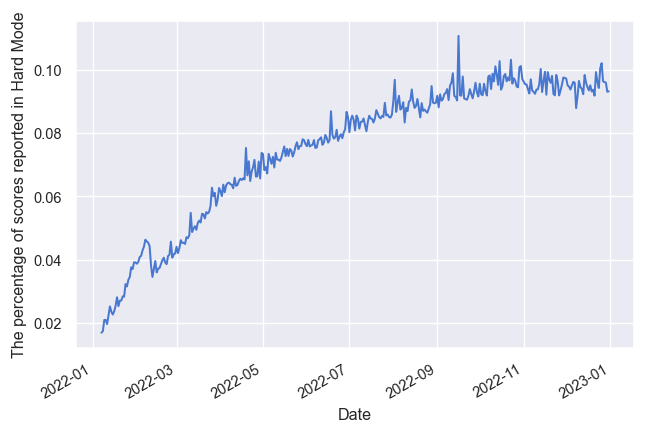

In [1029]:
fig = plt.figure(figsize=(6,4),dpi=120)
data.loc["2022-01-01":,"Hard Ratio"].plot(color=colors[0])
plt.ylabel("The percentage of scores reported in Hard Mode")

* The percetage $P(t)$ has an obvious upward trend in time
* The growth of $P(t)$ slows down with time, and then approaches to a steady state

We can assume that as time goes by: 
* **the number of players who join in the fun gradually decreases**, 
* **the proportion of hardcore players among the remaining players continues to rise**, and finally reaches a stable state

Fiset guess, we assume the percentage $P(t)$ satisfies the following model:
$$
P(t) = \mu(t) + \varepsilon_t
$$

We can **use a growth rate decay curve** to model $\mu(t)$: 
$$
\mu(t) = p_0 - ae^{-\beta\cdot t}
$$

In [1030]:
# Part II
def percentage_curve(t, p0, a, beta):
    return p0 - a*np.exp(-beta*t)
ydata = features["Hard Ratio"].values
opt_param, cov_param, lower, upper = curve_fit_estimate(ydata,percentage_curve)
percentage_pred = curve_fit_predict(len(ydata),percentage_curve,opt_param,cov_param,directions=[True,False,True])
print("Percentage Model Coef:")
print("p0 : {:.4f}, a: {:.4f}, beta: {:.4f}".format(*opt_param))
print("95% lower bound p0 : {:.4f}, a: {:.4f}, beta: {:.4f}".format(*lower))
print("95% upper bound p0 : {:.4f}, a: {:.4f}, beta: {:.4f}".format(*upper))
print("="*60)

Percentage Model Coef:
p0 : 0.1029, a: 0.0848, beta: 0.8040
95% lower bound p0 : 0.1016, a: 0.0835, beta: 0.7642
95% upper bound p0 : 0.1042, a: 0.0862, beta: 0.8439


Text(0.5, 0, 'Date')

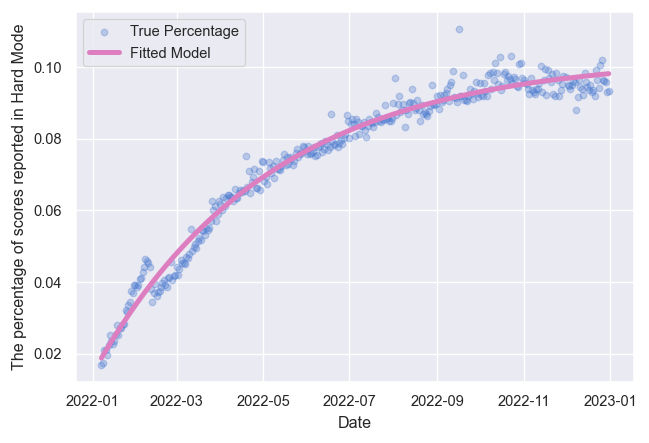

In [1072]:
fig = plt.figure(figsize=(6,4),dpi=120)
plt.scatter(data.index,data["Hard Ratio"],color=colors[0],s=15,alpha=0.3,label="True Percentage")
plt.ylabel("The percentage of scores reported in Hard Mode")
plt.plot(data.index,percentage_pred["center"],color=colors[6],lw=3,label="Fitted Model")
plt.legend()
plt.xlabel("Date")

Next, we fetch the residuals and to analyze **whether the residual sequence is stationary white noise**

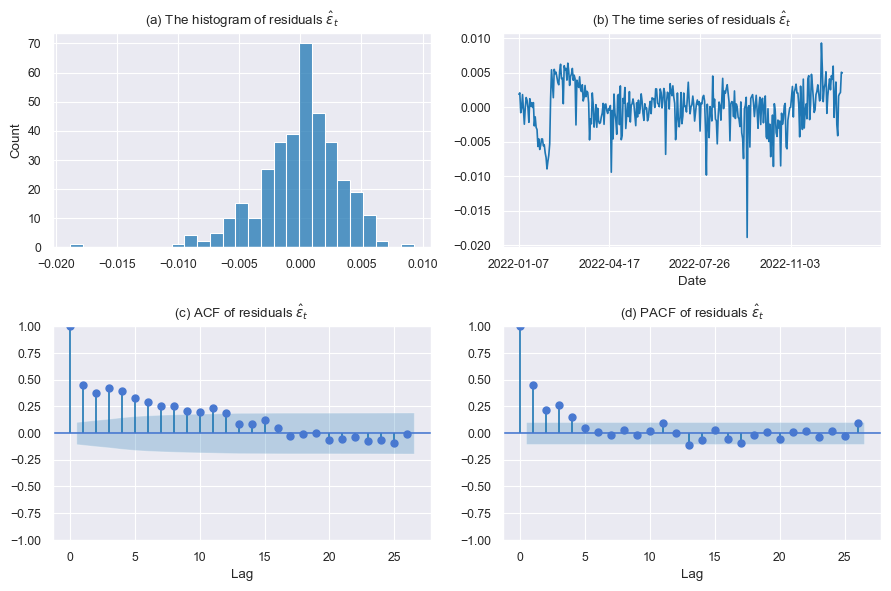

In [1046]:
residuals = pd.Series(data=percentage_pred["center"].values - features["Hard Ratio"].values,index=features.index)
fig, ax = plt.subplots(2,2,figsize=(9,6))
ax = ax.flatten()
sns.histplot(residuals,ax=ax[0])
ax[0].set_title("(a) The histogram of residuals $\hat{\\varepsilon}_t$")
residuals.plot(ax=ax[1])
ticks = ax[1].get_xticks()
labels = ax[1].get_xticklabels()
ax[1].set_xticks(ticks[1::2])
ax[1].set_xticklabels(labels[1::2])
ax[1].set_title("(b) The time series of residuals $\hat{\\varepsilon}_t$")
fig = plot_acf(residuals,ax=ax[2],color=colors[0])
ax[2].set_title("(c) ACF of residuals $\hat{\\varepsilon}_t$")
ax[2].set_xlabel("Lag")
fig = plot_pacf(residuals,ax=ax[3],method="ywm",color=colors[0])
ax[3].set_title("(d) PACF of residuals $\hat{\\varepsilon}_t$")
ax[3].set_xlabel("Lag")
plt.tight_layout()

We observed that:
* **The residual sequence of removing the trend item is not stable**, and
* **We observed the tail phenomenon from the ACF graph**.

In [221]:
residuals_test = adfuller(residuals)
print("Original Series ADF p-value: %.6f"%(residuals_test[1]))

Original Series ADF p-value: 0.000283


In [222]:
residuals_diff = residuals.diff(1)
residuals_diff = residuals_diff.loc[residuals_diff.notna()]
residuals_diff_test = adfuller(residuals_diff)
print("Diff 1 Series ADF p-value: %.6f"%(residuals_diff_test[1]))

Diff 1 Series ADF p-value: 0.000000


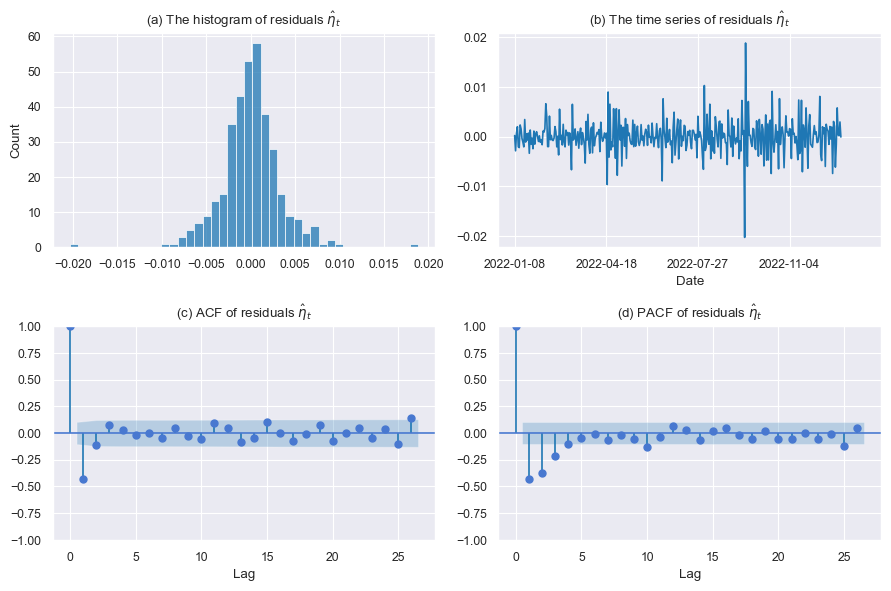

In [1047]:
fig, ax = plt.subplots(2,2,figsize=(9,6))
ax = ax.flatten()
sns.histplot(residuals_diff,ax=ax[0])
ax[0].set_title("(a) The histogram of residuals $\hat{\\eta}_t$")
residuals_diff.plot(ax=ax[1])
ticks = ax[1].get_xticks()
labels = ax[1].get_xticklabels()
ax[1].set_xticks(ticks[1::2])
ax[1].set_xticklabels(labels[1::2])
ax[1].set_title("(b) The time series of residuals $\hat{\\eta}_t$")
fig = plot_acf(residuals_diff,ax=ax[2],color=colors[0])
ax[2].set_title("(c) ACF of residuals $\hat{\\eta}_t$")
ax[2].set_xlabel("Lag")
fig = plot_pacf(residuals_diff,ax=ax[3],method="ywm",color=colors[0])
ax[3].set_title("(d) PACF of residuals $\hat{\\eta}_t$")
ax[3].set_xlabel("Lag")
plt.tight_layout()

Now, the sequence after the first order difference $\eta_t$ is stable and normal, but the ACF graph **still has the 1-Lag tail**. We use **AR(1)** model to model $\eta_t$

$$
\eta_t = \varepsilon_t - \varepsilon_{t-1} \\
\eta_t = \alpha\cdot \eta_{t-1} + \beta^TX_{t-1}
$$

in which, $\beta,X_{t-1}\in \mathbb{R}^p$ and $X_{t-1}$ is the target word features at $t-1$. That is, we assume that **the change of** $\varepsilon_t$ **on day** $t$ **is related to the word on day** $t-1$

Now, we create an OLS model to fit the residual changes $\{\eta_t\}$.

In [248]:
# fetch data
cols = features.columns[12:] # fetch features
Xdata = features.loc[:,cols]
# scale data
# numerical cols
num_cols = list(cols)
num_cols.remove("continuous")
Xdata[num_cols] = (Xdata[num_cols] - Xdata[num_cols].mean()) / Xdata[num_cols].std()
Xdata = pd.DataFrame(data=Xdata.iloc[1:-1].values,columns=cols,index=residuals_diff.index[1:])
Xdata = sm.add_constant(Xdata) # add constant
Xdata["eta"] = residuals_diff[0:-1].values # the previous day eta_{t-1}
Xdata["eta"] = ( Xdata["eta"] -  Xdata["eta"].mean()) / Xdata["eta"].std()
ydata = residuals_diff[1:] # predict eta_t
ydata = ydata / ydata.std()

In [249]:
ols_model = sm.OLS(ydata,Xdata)
result = ols_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     7.677
Date:                Sat, 18 Feb 2023   Prob (F-statistic):           8.35e-15
Time:                        12:59:00   Log-Likelihood:                -452.72
No. Observations:                 356   AIC:                             937.4
Df Residuals:                     340   BIC:                             999.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0339      0.051      0.659      0.510      -0.067       0.135
f_pos_1       -0.0665      0.052     -1.268      0.206      -0.170       0.037
f_pos_2        0.0108      0.085      0.127      0.899      -0.156       0.178
f_pos_3       -0.0949      0.062     -1.536      0.126      -0.216       0.027
f_pos_4        0.0859      0.073      1.170      0.243      -0.058       0.230
f_pos_5        0.0833      0.062      1.350      0.178      -0.038       0.205
f_let_1        0.0559      0.061      0.923      0.356      -0.063       0.175
f_let_2       -0.0650      0.083     -0.780      0.436      -0.229       0.099
f_let_3        0.0515      0.055      0.932      0.352      -0.057       0.160
f_let_4       -0.0176      0.068     -0.258      0.796      -0.152       0.116
f_let_5       -0.0109      0.066     -0.166      0.868      -0.140       0.118
gini          -0.1365      0.069     -1.971      0.050      -0.273      -0.000
continuous    -0.2864      0.196     -1.459      0.146      -0.673       0.100
gain_1         0.0688      0.123      0.559      0.576      -0.173       0.311
gain_2        -0.2106      0.120     -1.749      0.081      -0.447       0.026
eta           -0.3411      0.051     -6.705      0.000      -0.441      -0.241
==============================================================================
Omnibus:                       79.081   Durbin-Watson:                   2.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              396.075
Skew:                          -0.825   Prob(JB):                     9.85e-87
Kurtosis:                       7.897   Cond. No.                         7.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can observe that the coefficients with some characteristics are significant (**over 10%**):
* gini
* gain_2
* eat (1-Lag for $\eta_t$)

Next, we remove most of the insignificant features and re-fit the residuals to obtain a more accurate estimate of the coefficients

In [250]:
# fetch data
cols = features.columns[22:] # fetch features
Xdata = features.loc[:,cols]
# scale data
# numerical cols
num_cols = list(cols)
num_cols.remove("continuous")
Xdata[num_cols] = (Xdata[num_cols] - Xdata[num_cols].mean()) / Xdata[num_cols].std()
Xdata = pd.DataFrame(data=Xdata.iloc[1:-1].values,columns=cols,index=residuals_diff.index[1:])
Xdata = sm.add_constant(Xdata) # add constant
Xdata["eta"] = residuals_diff[0:-1].values # the previous day eta_{t-1}
Xdata["eta"] = ( Xdata["eta"] -  Xdata["eta"].mean()) / Xdata["eta"].std()
ydata = residuals_diff[1:] # predict eta_t
ydata = ydata / ydata.std()

In [251]:
ols_model = sm.OLS(ydata,Xdata)
result = ols_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     20.87
Date:                Sat, 18 Feb 2023   Prob (F-statistic):           2.96e-18
Time:                        13:00:08   Log-Likelihood:                -458.20
No. Observations:                 356   AIC:                             928.4
Df Residuals:                     350   BIC:                             951.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0353      0.051      0.692      0.490      -0.065       0.136
gini          -0.1229      0.062     -1.976      0.049      -0.245      -0.001
continuous    -0.2945      0.185     -1.588      0.113      -0.659       0.070
gain_1         0.0050      0.117      0.043      0.966      -0.225       0.235
gain_2        -0.1744      0.115     -1.514      0.131      -0.401       0.052
eta           -0.3540      0.050     -7.012      0.000      -0.453      -0.255
==============================================================================
Omnibus:                       77.892   Durbin-Watson:                   2.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.219
Skew:                          -0.795   Prob(JB):                     2.27e-89
Kurtosis:                       7.999   Cond. No.                         6.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now there is another feature with **more than 5% significance** 
* gini
* eta (1-Lag for $\eta_t$)

Finally, we can write down our model for $P(t)$

First, the residual changes $\eta_t$ has an AR(1) precess:
$$
\eta_t = \varepsilon_t - \varepsilon_{t-1} =\alpha\cdot \eta_{t-1} + \beta^TX_{t-1}
$$

Thus, the residual can be modeled as:
$$
\begin{array}{rcl}
\varepsilon_t & = & \varepsilon_{t-1} + \alpha\cdot \eta_{t-1} + \beta^TX_{t-1} \\
& = & \varepsilon_{t-1} + \alpha\cdot \left(\alpha\cdot \eta_{t-2} + \beta^T X_{t-2} \right) + \beta^TX_{t-1} \\
& = & \cdots \\
& = & \displaystyle{ \varepsilon_{t-1} + \beta^T \sum_{k=1}^{K} \alpha^{k-1}X_{t-k}  + \alpha^K\eta_{t-K}}
\end{array}
$$

We substitute the above model into the expression of $P(t)$, and the final model is 
$$
P(t) = \mu(t) + \varepsilon_t = \mu(t) + \epsilon_{t-1} + \beta^T\sum_{k=1}^{K} \alpha^{k-1}X_{t-k} + \alpha^K\eta_{t-K}
$$

in which, $|\alpha| < 1$. Therefore, over time, **the impact of the features of the target word in the previous few days** on the current percentage $P(t)$ **decreases exponentially**.

In our model, $|\alpha|$ is about 0.354, so **the influence of the word attributes five days ago** $X_{t-5}$ on the current $P(t)$ **is only close to 1%**.

----

### **Question 2**

We use `softmax()` function to model the distribution, and then maximize the logarithmic likelihood function to estimate parameters.

In [4]:
distributions = features.iloc[:,4:11] / np.sum(features.iloc[:,4:11].values,axis=1,keepdims=True)
# distributions.head(50)

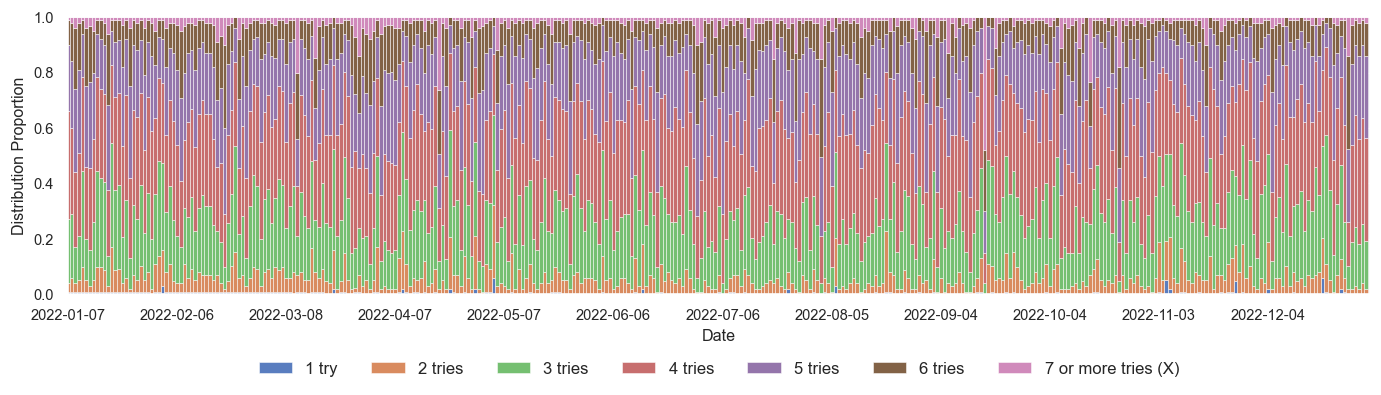

In [61]:
colors = sns.palettes.color_palette("muted")
fig, ax = plt.subplots(figsize=(14,3),dpi=120)
xticks = list(range(len(distributions)))
sns.barplot(x=xticks,y=distributions["1 try"].values,color=colors[0],
            label=distributions.columns[0],ax=ax,width=1,linewidth=0.3)
bottom = distributions["1 try"].values.copy()
for i in range(6):
    sns.barplot(x=xticks,y=distributions.iloc[:,i+1].values,ax=ax,
                bottom=bottom,color=colors[i+1],label=distributions.columns[i+1],width=1,linewidth=0.3)
    bottom += distributions.iloc[:,i+1].values.copy()
ax.set_xticks(xticks[::30])
ax.set_xticklabels(distributions.index[::30])
ax.set_ylabel("Distribution Proportion")
ax.set_xlabel("Date")
ax.set_xlim([0,len(distributions)])
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), 
           ncol=7, title=None, frameon=False,edgecolor="red",fontsize=10, bbox_transform=ax.transAxes)

For each possible state $k=1,2,\cdots,7$, each word $W$ and time index $t$, assume the distribution we wwant to predict is $Y_k(t)$:
$$
\sum_{k=1}^{7} P_k(t) = 1,\quad \forall t
$$
we define the logits $L_k(W,t)$ as:
$$
L_k(W,t) = \beta_S^T S + \beta_D^T D
$$

* $S\in\mathbb{R}^{p_1}$ is the **static features** of the model, $S$ in cludes the words attributes.
* $D\in\mathbb{R}^{p_2}$ is the **dynamic features** of the model, which is related to playere and time index $t$. Examples include the following features: 
  * Current time index $t$ and its higher-order moments like $t^2$
  * Proportion $P(t)$ of time $t$ to play Hard Mode, which we discussed in Question 1.
  * In the past period of time (**taking the window parameter M**), **the player's comprehensive performance** $C_k(t)$ is calculated, and the **average value of the distribution of the past M days**. 
  $$
  C_k(t) = \frac{1}{M}\sum_{i=1}^{M} P_k(t-i)
  $$

Now, we can define our distribution model using `softmax()` functions:
$$
\hat{P}_k(t) = \frac{ \exp{ L_k(W,t) } }{ \sum_{j=1}^{7} \exp{ L_j(W,t) } }\in (0,1),\quad k=1,2,\cdots,7\quad\text{and}\quad \sum_{k=1}^{7} \hat{P}_k(t) = 1
$$

We **estimate the model parameters by maximizing the log-likelihood function** $\ell$ (or say using Cross-Entropy loss)

$$
\ell = \sum_{t} \text{CrossEntropy}(P(t),\hat{P}(t)) = -\sum_{t}\left( \sum_{k=1}^{7} P_k(t)\cdot \log\hat{P}_k(t) \right)
$$

In [62]:
def cross_entropy(p : np.ndarray, q : np.ndarray):
    """
    cross entropy function.

    Parameters
    ----------
    p : np.ndarray
        The true prob distribution of the data.
    q : np.ndarray
        The pred prob distribution of the data.
    """
    if p.ndim == 1:
        return -(p*np.log(q + 1e-16)).sum()
    return -(p*np.log(q + 1e-16)).sum(axis=1)

In [63]:
def KL_divergence(p : np.ndarray, q : np.ndarray):
    """
    Calculate KL divergence.

    Parameters
    ----------
    p : np.ndarray
        The true prob distribution of the data.
    q : np.ndarray
        The pred prob distribution of the data.
    """
    return cross_entropy(p,q) - cross_entropy(p,p)

In [64]:
def softmax(x : np.ndarray):
    x_exp = np.exp(x)
    if x.ndim == 1:
        return x_exp / x_exp.sum()
    return x_exp / np.sum(x_exp,keepdims=True,axis=1)

Defien a function `build_question2_features()` to generate data we need.

In [277]:
def build_question2_features(M : int=10, return_scaler : bool=False, version : int=2):
    """
    Parameters
    ----------
    M : int, default = 10
        The windows size to generate historical comprehensive performance `C`
    """
    # static features
    if version == 1:
        features = pd.read_csv("./data_with_features.csv",index_col=0)
    elif version == 2:
        features = pd.read_csv("./data_with_features_ver2.csv",index_col=0)
    S = features.iloc[:,12:].copy()

    # dynamic features
    time = pd.Series(index=S.index,data=np.arange(len(features)) / 100,name="time")
    CP = distributions.rolling(M).mean().shift(1) # average performance
    # merge features
    merge_fetures = pd.concat([S,time,features["Hard Ratio"],CP],axis=1)
    merge_fetures.dropna(axis=0,inplace=True)

    # scale data
    cols = list(merge_fetures.columns)
    if version == 1:    
        removed_cols = ["continuous","time"]
    elif version == 2:
        removed_cols = ["continuous","time","pron","adj","adv","n","v"]
    for col in removed_cols:
        cols.remove(col)
    # for col in merge_fetures.columns[-7:]:
    #     cols.remove(col)
    mean, std = merge_fetures[cols].mean(), merge_fetures[cols].std()
    merge_fetures.loc[:,cols] = ((merge_fetures[cols] - mean) / std).values

    # prepare labels
    prob_true = distributions.loc[merge_fetures.index]
    # print(merge_fetures.columns)

    if return_scaler:
        return merge_fetures.values.copy(), prob_true.values.copy(), (cols, mean, std)
    return merge_fetures.values.copy(), prob_true.values.copy()

In [67]:
def predict_distribution(beta : np.ndarray, features : np.ndarray):
    """
    Predict prob distribution for given data.
    """
    p = features.shape[1]
    beta = beta.reshape(p,7)
    logits = features @ beta
    p_hat = softmax(logits)

    return p_hat

In [68]:
def solve_question2(features : np.ndarray, distributions : np.ndarray):
    def objective(beta : np.ndarray, X, p_true):
        p_hat = predict_distribution(beta,X) # predict distribution
        loss = cross_entropy(p_true,p_hat) # calculate loss
        return np.mean(loss)
    
    p = features.shape[1]
    beta0 = np.random.randn(p*7) # init paramters
    res = minimize(objective,beta0,(features,distributions),tol=1e-4)
    
    return res

In [72]:
merge_fetures, prob_true = build_question2_features()
X_train, X_valid, y_train, y_valid = train_test_split(merge_fetures,prob_true,test_size=0.3)
res = solve_question2(X_train,y_train)
res.success

Index(['word_freq', 'f_pos_1', 'f_pos_2', 'f_pos_3', 'f_pos_4', 'f_pos_5',
       'f_let_1', 'f_let_2', 'f_let_3', 'f_let_4', 'f_let_5', 'gini',
       'continuous', 'pron', 'adj', 'adv', 'n', 'v', 'gain_1', 'gain_2',
       'time', 'Hard Ratio', '1 try', '2 tries', '3 tries', '4 tries',
       '5 tries', '6 tries', '7 or more tries (X)'],
      dtype='object')


True

In [73]:
# before training
beta_random = np.random.randn(X_train.shape[1]*7)
ce_train = KL_divergence(y_train,predict_distribution(beta_random,X_train)).mean()
ce_valid = KL_divergence(y_valid,predict_distribution(beta_random,X_valid)).mean()
print("="*50)
print("Before Training")
print("KL divergence Loss for train: %.4f"%(ce_train))
print("KL divergence Loss for valid: %.4f"%(ce_valid))

# aftere training
ce_train = KL_divergence(y_train,predict_distribution(res.x,X_train)).mean()
ce_valid = KL_divergence(y_valid,predict_distribution(res.x,X_valid)).mean()
print("="*50)
print("After Training")
print("KL divergence Loss for train: %.4f"%(ce_train))
print("KL divergence Loss for valid: %.4f"%(ce_valid))

Before Training
KL divergence Loss for train: 4.8333
KL divergence Loss for valid: 4.4152
After Training
KL divergence Loss for train: 0.0355
KL divergence Loss for valid: 0.0375


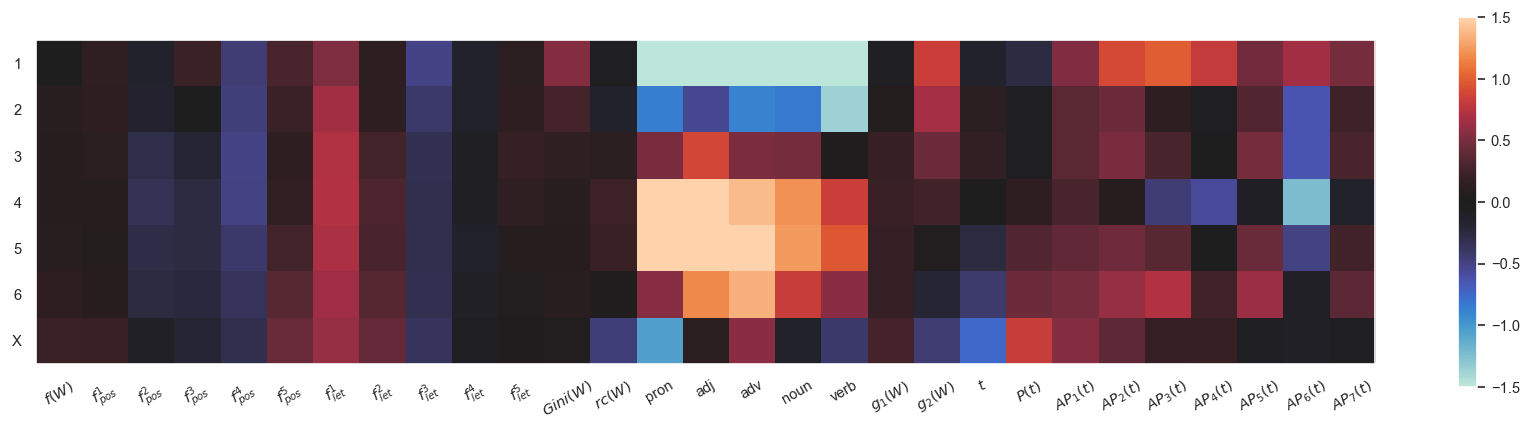

In [235]:
fig = plt.figure(figsize=(18,4),dpi=120)
sns.set_style("dark")
plt.imshow(res.x.reshape(29,7).T,cmap=sns.cm.icefire,vmin=-1.5,vmax=1.5)
cols = ['$f(W)$',"$f_{pos}^1$", "$f_{pos}^2$", "$f_{pos}^3$", "$f_{pos}^4$", "$f_{pos}^5$",
        "$f_{let}^1$", "$f_{let}^2$","$f_{let}^3$", "$f_{let}^4$", "$f_{let}^5$", 
        '$Gini(W)$', '$rc(W)$', 'pron', 'adj', 'adv', 'noun', 'verb', '$g_1(W)$', '$g_2(W)$',
        '$t$', "$P(t)$", "$AP_1(t)$", "$AP_2(t)$", "$AP_3(t)$", "$AP_4(t)$", "$AP_5(t)$", "$AP_6(t)$", "$AP_7(t)$"]

plt.xticks(list(range(X_train.shape[1])),cols,rotation=30)
plt.yticks(list(range(7)),[1,2,3,4,5,6,"X"])
# position=fig.add_axes([0.15, 0.05, 0.7, 0.03])
plt.colorbar()

We need to adjuest the hyper-parameter $M$

In [237]:
def adjust_parameter_question2(M_list : list, valid_size : list):
    kl_trains, kl_valids = [], []
    for M in tqdm(M_list):
        kl_train, kl_valid = 0, 0
        for size in valid_size:
            merge_fetures, prob_true = build_question2_features(M=M)
            X_train, y_train = merge_fetures[0:-size], prob_true[0:-size]
            X_valid, y_valid = merge_fetures[-size:], prob_true[-size:]
            res = solve_question2(X_train,y_train)
            kl_train += KL_divergence(y_train,predict_distribution(res.x,X_train)).mean()
            kl_valid += KL_divergence(y_valid,predict_distribution(res.x,X_valid)).mean()
        kl_trains.append(kl_train / len(valid_size))
        kl_valids.append(kl_valid / len(valid_size))
    return kl_trains, kl_valids

In [242]:
M_list = [i for i in range(1,16)]
valid_size = [50, 75]
kl_trains, kl_valids = adjust_parameter_question2(M_list,valid_size)

100%|██████████| 15/15 [01:30<00:00,  6.04s/it]


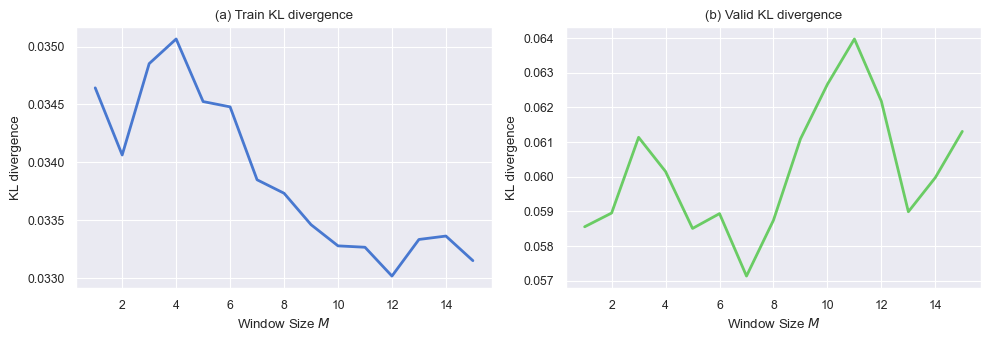

In [246]:
fig, ax = plt.subplots(1,2,figsize=(10,3.5))
ax = ax.flatten()
ax[0].plot(M_list,kl_trains,color=colors[0],lw=2,label="Train KL divergence")
ax[1].plot(M_list,kl_valids,color=colors[2],lw=2,label="Valid KL divergence")
ax[0].set_xlabel("Window Size $M$")
ax[0].set_ylabel("KL divergence")
ax[0].set_title("(a) Train KL divergence")
ax[1].set_xlabel("Window Size $M$")
ax[1].set_ylabel("KL divergence")
ax[1].set_title("(b) Valid KL divergence")
plt.tight_layout()

From figure above, set $M = 5$ may be a good choice. **The larger the window size, the more serious the overfitting**

Next, we can fetch several case to see the predictions.

In [261]:
merge_fetures, prob_true = build_question2_features(M=1)
X_train, X_valid, y_train, y_valid = train_test_split(merge_fetures,prob_true,test_size=0.3,random_state=42)
size, start = 60, 50
X_train, y_train = merge_fetures[start:-size], prob_true[start:-size]
X_valid, y_valid = merge_fetures[-size:], prob_true[-size:]
res = solve_question2(X_train,y_train)
y_train_pred = predict_distribution(res.x,X_train)
y_valid_pred = predict_distribution(res.x,X_valid)

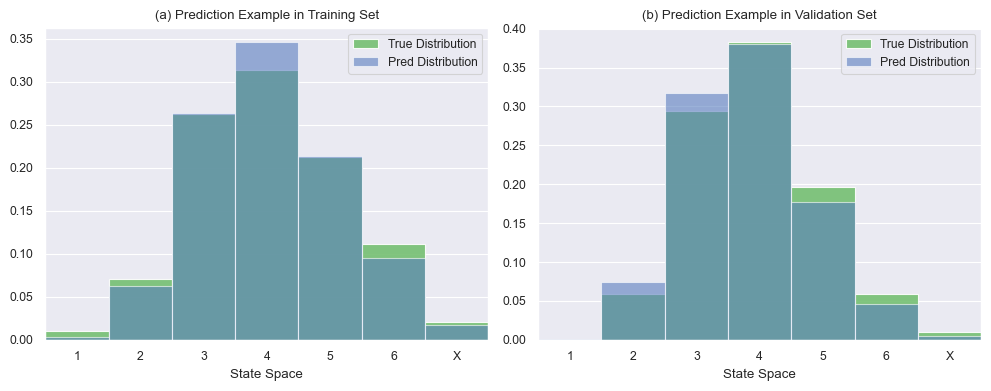

In [276]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax = ax.flatten()
ticks = [1,2,3,4,5,6,7]

train_idx = 3
sns.barplot(x=ticks,y=y_train[train_idx],ax=ax[0],color=colors[2],alpha=0.9,width=1,label="True Distribution")
sns.barplot(x=ticks,y=y_train_pred[train_idx],ax=ax[0],color=colors[0],alpha=0.6,width=1,label="Pred Distribution")
ax[0].set_xlabel("State Space")
ax[0].set_xticklabels([1,2,3,4,5,6,"X"])
ax[0].set_title("(a) Prediction Example in Training Set")
ax[0].legend()

valid_idx = 1
sns.barplot(x=ticks,y=y_valid[valid_idx],ax=ax[1],color=colors[2],width=1,alpha=0.9,label="True Distribution")
sns.barplot(x=ticks,y=y_valid_pred[valid_idx],ax=ax[1],color=colors[0],width=1,alpha=0.6,label="Pred Distribution")
ax[1].set_xlabel("State Space")
ax[1].set_xticklabels([1,2,3,4,5,6,"X"])
ax[1].set_title("(b) Prediction Example in Validation Set")
ax[1].legend()
plt.tight_layout()

We can draw average prediction error.

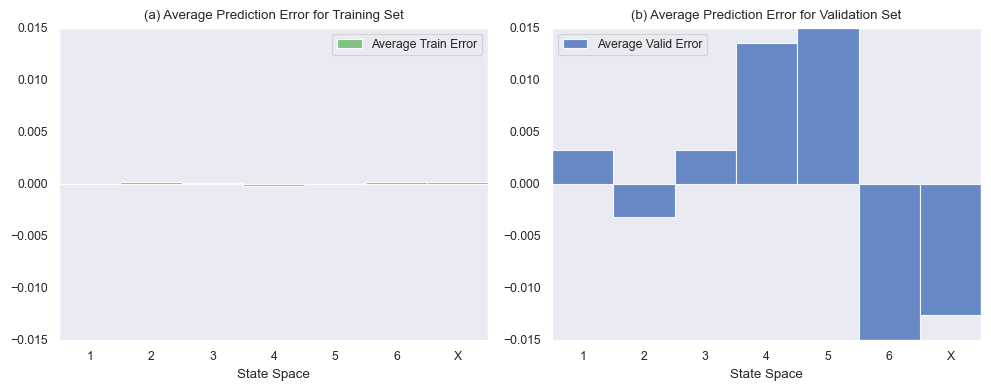

In [230]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax = ax.flatten()
ticks = [1,2,3,4,5,6,7]

train_err = (y_train_pred - y_train).mean(axis=0)
sns.barplot(x=ticks,y=train_err,ax=ax[0],color=colors[2],alpha=0.9,width=1,label="Average Train Error")
ax[0].set_xlabel("State Space")
ax[0].set_xticklabels([1,2,3,4,5,6,"X"])
ax[0].set_title("(a) Average Prediction Error for Training Set")
ax[0].set_ylim([-0.015,0.015])
ax[0].legend()

valid_err = (y_valid_pred - y_valid).mean(axis=0)
sns.barplot(x=ticks,y=valid_err,ax=ax[1],color=colors[0],width=1,alpha=0.9,label="Average Valid Error")
ax[1].set_xlabel("State Space")
ax[1].set_xticklabels([1,2,3,4,5,6,"X"])
ax[1].set_title("(b) Average Prediction Error for Validation Set")
ax[1].set_ylim([-0.015,0.015])
ax[1].legend()
plt.tight_layout()

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, 'X')]

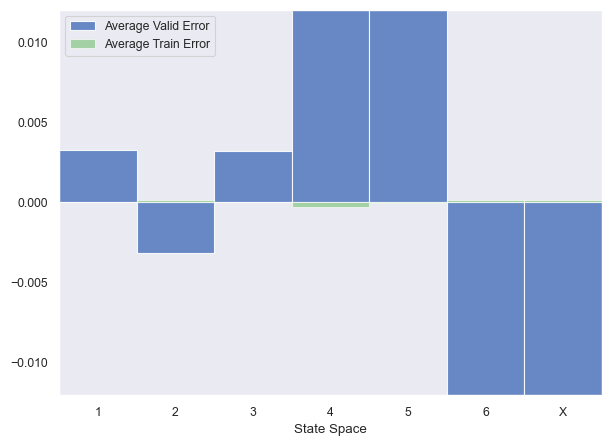

In [231]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=ticks,y=valid_err,ax=ax,color=colors[0],alpha=0.9,width=1,label="Average Valid Error")
sns.barplot(x=ticks,y=train_err,ax=ax,color=colors[2],alpha=0.6,width=1,label="Average Train Error")
ax.legend()
ax.set_ylim([-0.012,0.012])
ax.set_xlabel("State Space")
ax.set_xticklabels([1,2,3,4,5,6,"X"])

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, 'X')]

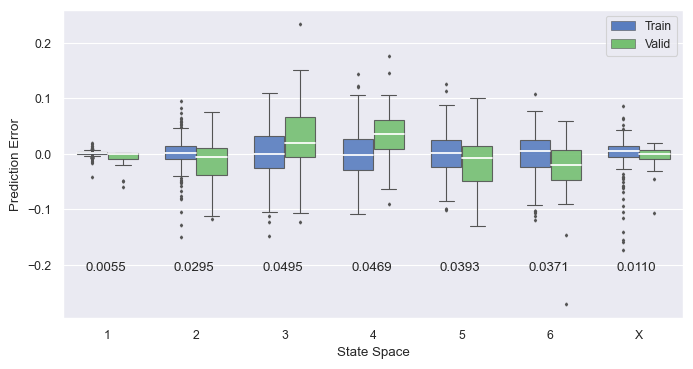

In [275]:
ticks = [1,2,3,4,5,6,7]
train_err = pd.DataFrame((y_train_pred - y_train),columns=["1","2","3","4","5","6","X"])
train_err["dataset"] = "Train" 
valid_err = pd.DataFrame((y_valid_pred - y_valid),columns=["1","2","3","4","5","6","X"])
valid_err["dataset"] = "Valid"
err = pd.concat([train_err,valid_err],axis=0).reset_index(drop=True)
err = err.melt(id_vars="dataset")
fig, ax = plt.subplots(figsize=(8,4))

sns.boxplot(err,x="variable",y="value",hue="dataset", palette=[colors[0],colors[2]],
            fliersize=1.5,linewidth=0.8,ax=ax,width=0.7,
            boxprops={"alpha":0.9},medianprops={"color":"white","linewidth":1.25})
for i,val in enumerate(valid_err.iloc[:,:-1].abs().mean()):
    ax.text(i-0.25,0-0.21,"%.4f"%(val))
ax.legend()
# ax.set_ylim([-0.012,0.012])
ax.set_xlabel("State Space")
ax.set_ylabel("Prediction Error")
ax.set_xticklabels([1,2,3,4,5,6,"X"])

Now, we move to make prediction for the future `date` $t$ and `word` $W$

In [341]:
def question2_rolling_prediction(date : str, target : str, words_list : list, 
                                 gain_1 : pd.Series=None, gain_2 : pd.Series=None, M : int=5):
    date = pd.to_datetime(date)
    merge_fetures, prob_true, scaler = build_question2_features(M=M,return_scaler=True,version=1)
    res = solve_question2(merge_fetures,prob_true)
    beta = res.x

    features = pd.read_csv("./data_with_features.csv",index_col=0)
    distributions = features.iloc[:,4:11] / np.sum(features.iloc[:,4:11].values,axis=1,keepdims=True)
    distributions.index = distributions.index.map(pd.to_datetime)

    cols = ['f_pos_1', 'f_pos_2', 'f_pos_3', 'f_pos_4', 'f_pos_5',
            'f_let_1', 'f_let_2','f_let_3', 'f_let_4', 'f_let_5', 
            'gini', 'continuous', 'gain_1', 'gain_2',
            'time', "Hard Ratio", '1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7 or more tries (X)']
    merge_fetures = pd.DataFrame(
        data=merge_fetures,
        index=features.index[-len(merge_fetures):],
        columns=cols)
    merge_fetures.index = merge_fetures.index.map(pd.to_datetime)

    pred_days = (date - merge_fetures.index[-1]).days
    assert len(words_list) >= pred_days

    np.random.shuffle(words_list) # shuffle the order
    words_list[pred_days-1] = target # assign target word

    def percentage_curve(t, p0, a, beta):
        return p0 - a*np.exp(-beta*t)
    ydata = features["Hard Ratio"].values
    opt_param, _, _, _ = curve_fit_estimate(ydata,percentage_curve)
    percentage_pred = curve_fit_predict(
        len(ydata) + pred_days,percentage_curve,opt_param,cov_param,directions=[True,False,True])
    percentage_pred = percentage_pred["center"][-pred_days:].values

    day = merge_fetures.index[-1]
    next_day = day + pd.DateOffset(days=1)
    for i in range(pred_days):
        # generate word features
        feat = build_single_word_features(words_list[i])
        # gain round 1
        if gain_1 is None:
            feat.append(build_gain_recur(words_list[i],pivot_wordle_score,valid_words_freq,rounds=1)[1])
        else:
            feat.append(gain_1[words_list[i]])
        # gain round 2
        if gain_2 is None:
            feat.append(build_gain_recur(words_list[i],pivot_wordle_score,valid_words_freq,rounds=2)[1])
        else:
            feat.append(gain_2[words_list[i]])
        # add time
        feat.append(merge_fetures.loc[day,"time"] + 0.01)
        # predict hard ratio
        feat.append(percentage_pred[i])
        # add history comprehensive performance
        CP = distributions.iloc[-M:,:].mean(axis=0)
        feat.extend(CP.to_list())
        
        merge_fetures.loc[next_day] = feat
        merge_fetures.loc[next_day,scaler[0]] = (merge_fetures.loc[next_day,scaler[0]] - scaler[1]) / scaler[2]
        
        # make prediction
        p_hat = predict_distribution(beta,merge_fetures.loc[[next_day]].values)
        distributions.loc[next_day] = p_hat.flatten() # assign to distribution

        # update date
        day = next_day
        next_day = next_day + pd.DateOffset(days=1)

    return merge_fetures, distributions

In [342]:
gain_1 = pd.read_csv("./target_word_gain_1_samples.csv",index_col=0)["0"]
gain_2 = pd.read_csv("./target_word_gain_2_samples.csv",index_col=0)["0"]
words_list = gain_1.index.to_list()
words_list.remove("eerie")

In [367]:
# test
merge_df, pred_dist = question2_rolling_prediction(
    date="2023-03-01",target="eerie",words_list=words_list,gain_1=gain_1,gain_2=gain_2,M=1)

In [369]:
def bootstrap_rolling_predictions(
        date : str, word : str, words_list : list, gain_1 : pd.Series=None, gain_2 : pd.Series=None,
        B : int=100, n_jobs : int=16):
    # parallel acceleration
    def helper_func(date : str, word : str, words_list : list):
        _, distribution = question2_rolling_prediction(
            date=date,target=word,words_list=words_list,gain_1=gain_1,gain_2=gain_2,M=1)
        return distribution.iloc[-1]
    
    # create param list
    params_list = []
    for b in range(B):
        params = {
            "date": date,
            "word": word,
            "words_list": words_list.copy()
        }
        params_list.append(params)
    
    result = multi_task(helper_func,params_list,n_job=n_jobs,verbose=1)
    for b in range(B):
        result[b].name = b
    result = pd.concat(result,axis=1).T

    return result

In [394]:
boostrap_result = bootstrap_rolling_predictions(
    date="2023-03-01",word="eerie",words_list=words_list,
    gain_1=gain_1,gain_2=gain_1,B=500,n_jobs=30
)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:  2.3min
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:  6.2min
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:  7.9min finished


(0.0, 0.01)

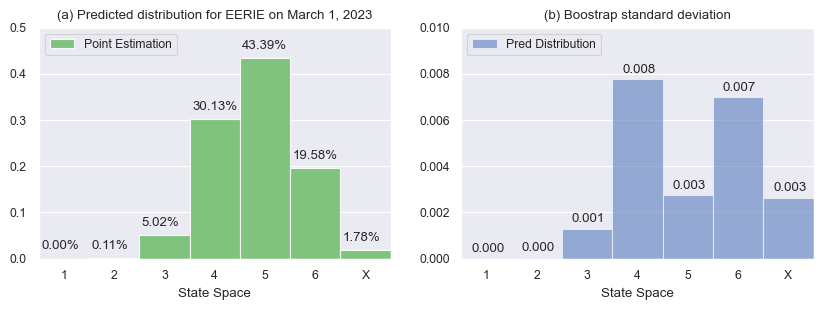

In [439]:
point_estimation = boostrap_result.mean(axis=0)
# point_estimation /= point_estimation.sum()
bootstrap_std = boostrap_result.std(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax = ax.flatten()
ticks = [1,2,3,4,5,6,7]

train_idx = 3
sns.barplot(x=ticks,y=point_estimation,ax=ax[0],color=colors[2],alpha=0.9,width=1,label="Point Estimation")
sns.barplot(x=ticks,y=bootstrap_std,ax=ax[1],color=colors[0],alpha=0.6,width=1,label="Pred Distribution")
ax[0].set_xlabel("State Space")
ax[0].set_xticklabels([1,2,3,4,5,6,"X"])
ax[0].set_title("(a) Predicted distribution for EERIE on March 1, 2023")
for i in range(7):
    ax[0].text(i-0.45,point_estimation[i]+0.02,"%02.2f"%(100*point_estimation[i]) + "%")
ax[0].legend(loc="upper left")
ax[0].set_ylim([0,0.50])
ax[1].set_xlabel("State Space")
ax[1].set_xticklabels([1,2,3,4,5,6,"X"])
ax[1].set_title("(b) Boostrap standard deviation")
for i in range(7):
    ax[1].text(i-0.3,bootstrap_std[i]+0.0003,"%.3f"%(bootstrap_std[i]))
ax[1].legend(loc="upper left")
ax[1].set_ylim([0,0.01])

------

### **Question 3: Classification**

In [2]:
features = pd.read_csv("./data_with_features.csv",index_col=0)
features.head()

,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,...,f_pos_5,f_let_1,f_let_2,f_let_3,f_let_4,f_let_5,gini,continuous,gain_1,gain_2
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-07,202,slump,80630,1362,1,3,23,39,24,9,...,0.011332,0.234809,0.207357,0.265631,0.203441,0.072808,0.80,0,4.514074,6.464482
2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,...,0.019966,0.454635,0.226070,0.206344,0.266938,0.172093,0.80,0,4.383914,6.646222
2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,...,0.117330,0.388078,0.472285,0.288119,0.257299,0.228460,0.72,0,4.392876,6.544324
2022-01-10,205,query,107134,2242,1,4,16,30,30,17,...,0.100293,0.696429,0.472720,0.132393,0.172920,0.627290,0.80,0,4.068192,6.362597
2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,...,0.019966,0.279250,0.226070,0.279596,0.266938,0.172093,0.80,0,4.548086,6.896651


In [5]:
N = len(distributions)
avg_tries = np.repeat(np.array([1,2,3,4,5,6,7]),N).reshape((7,N)).T * distributions
avg_tries = avg_tries.sum(axis=1)

In [6]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

In [7]:
X = features.iloc[:,12:]
X.loc["2023-03-01"] = [ 0.02335800185013876,
                        0.12550107924761023,
                        0.09235275979031761,
                        0.06783842121492445,
                        0.11732963305581252,
                        0.04548183728610027,
                        0.24437105974181927,
                        0.2881192881192881,
                        0.2341048151104017,
                        0.22845992194536174,
                        0.5599999999999999,
                        1,
                        4.426501931756936,
                        6.833217878685496]
cols = list(X.columns)
cols.remove("continuous")
cols.remove("gini")
mean, std = X[cols].mean(), X[cols].std()
X[cols] = (X[cols] - mean) / std

In [8]:
quantiles = np.quantile(avg_tries,q=[0.1,0.7])
quantiles

array([3.69792079, 4.36363636])

In [9]:
labels = avg_tries.copy()
for i in range(len(quantiles)):
    if i == 0:
        labels[avg_tries <= quantiles[i]] = i
    elif i == len(quantiles) - 1:
        labels[avg_tries >= quantiles[i]] = i + 1
        labels[(avg_tries > quantiles[i-1]) & (avg_tries <= quantiles[i])] = i
    else:
        labels[(avg_tries > quantiles[i-1]) & (avg_tries <= quantiles[i])] = i

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:-1,:],labels,test_size=0.3)
model = LogisticRegression(penalty="l1",solver="saga",C=0.5,max_iter=5000,fit_intercept=False)
model.fit(X=X_train,y=y_train)

LogisticRegression(C=0.5, fit_intercept=False, max_iter=5000, penalty='l1',
                   solver='saga')

In [30]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    plot_confusion_matrix(y_true, y_pred)
        绘制混淆矩阵
        
    Parameters
    ----------
    y_true : np.ndarray
        数据的真实标签
    y_pred : np.ndarray
        模型的预测结果
    labels : list
        各个类别的含义
    """
    import itertools

    acc = accuracy_score(y_true, y_pred)
    mat = confusion_matrix(y_true, y_pred)
    print("accuracy: %.4f"%(acc))
    
    # 绘制混淆矩阵
    fig = plt.figure(figsize=(3,3),dpi=100)
    plt.imshow(mat,cmap=plt.cm.Blues)
    
    thresh = mat.max() / 2
    for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
        # 在每个位置添加上样本量
        plt.text(j, i, mat[i, j],
                 horizontalalignment="center",
                 color="white" if mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.xticks(range(mat.shape[0]),labels)
    plt.yticks(range(mat.shape[0]),labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

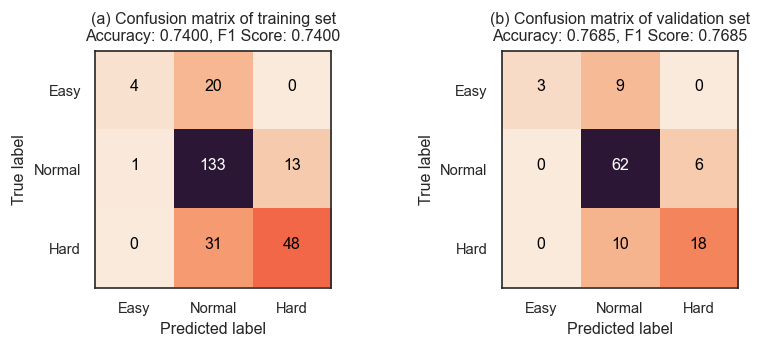

In [35]:
sns.set_style("white")
import itertools
label = ["Easy","Normal","Hard"]
fig,ax = plt.subplots(1,2,figsize=(7,3),dpi=120)
ax = ax.flatten()

mat = confusion_matrix(y_train, model.predict(X_train))
ax[0].imshow(mat,cmap=sns.cm.rocket_r,vmax=150)
thresh = mat.max() / 2
for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    # 在每个位置添加上样本量
    ax[0].text(j, i, mat[i, j],
                horizontalalignment="center",
                color="white" if mat[i, j] > thresh else "black")
    
mat = confusion_matrix(y_test, model.predict(X_test))
ax[1].imshow(mat,cmap=sns.cm.rocket_r,vmax=70)
thresh = mat.max() / 2
for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    # 在每个位置添加上样本量
    ax[1].text(j, i, mat[i, j],
                horizontalalignment="center",
                color="white" if mat[i, j] > thresh else "black")

for i in range(2):
    ax[i].set_xticks(range(mat.shape[0]))
    ax[i].set_xticklabels(label)
    ax[i].set_yticks(range(mat.shape[0]))
    ax[i].set_yticklabels(label)
    ax[i].set_ylabel('True label')
    ax[i].set_xlabel('Predicted label')
ax[0].set_title("(a) Confusion matrix of training set\nAccuracy: %.4f, F1 Score: %.4f"
                %(accuracy_score(y_train, model.predict(X_train)),f1_score(y_train,model.predict(X_train),average="micro")))
ax[1].set_title("(b) Confusion matrix of validation set\nAccuracy: %.4f, F1 Score: %.4f"
                %(accuracy_score(y_test, model.predict(X_test)),f1_score(y_test,model.predict(X_test),average="micro")))
plt.tight_layout()

In [13]:
from sklearn.metrics import f1_score

In [15]:
f1_score(y_train,model.predict(X_train),average="weighted")

0.727711408820158

In [16]:
f1_score(y_test,model.predict(X_test),average="weighted")

0.7123737373737374

accuracy: 0.7315


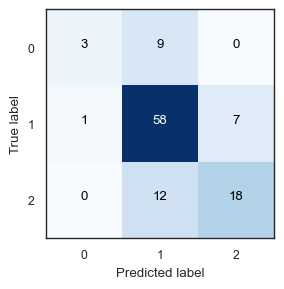

In [17]:
label_name = list(range(labels.nunique()))
plot_confusion_matrix(y_test,model.predict(X_test),label_name)

accuracy: 0.7480


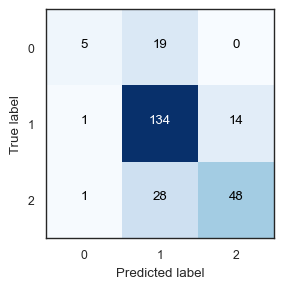

In [18]:
label_name = list(range(labels.nunique()))
plot_confusion_matrix(y_train,model.predict(X_train),label_name)

In [163]:
model.predict_proba(X)

array([[0.01906389, 0.56329194, 0.41764417],
       [0.03759816, 0.71630586, 0.24609599],
       [0.02512444, 0.25912756, 0.715748  ],
       ...,
       [0.17122833, 0.69746709, 0.13130458],
       [0.00634406, 0.2283705 , 0.76528544],
       [0.03942791, 0.33046475, 0.63010734]])

In [925]:
# do grid search to find best split quantile
splits = [0.10*i for i in range(1,10)] # spilit quantile
accs = {}
for s1 in tqdm(splits):
    s2 = s1 + 0.10
    while s2 < 0.95:
        quantiles = np.quantile(avg_tries,q=[s1,s2])

        # create labels
        labels = avg_tries.copy()
        for i in range(len(quantiles)):
            if i == 0:
                labels[avg_tries <= quantiles[i]] = i
            elif i == len(quantiles) - 1:
                labels[avg_tries >= quantiles[i]] = i + 1
                labels[(avg_tries > quantiles[i-1]) & (avg_tries <= quantiles[i])] = i
            else:
                labels[(avg_tries > quantiles[i-1]) & (avg_tries <= quantiles[i])] = i
        
        # do 20-Folds Validations
        acc = [] # save accuracy
        for i in range(20):
            X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size=0.3)
            model = LogisticRegression(penalty="l1",solver="saga",max_iter=5000,C=2,fit_intercept=False)
            model.fit(X=X_train,y=y_train)
            acc.append(accuracy_score(y_test,model.predict(X_test)))
        
        # calculate average acc and save results
        accs[str(s1) + "-" + str(s2)] = np.mean(acc)
        s2 += 0.10

100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


----

### **Question 4: Interesting Insights**

In [1317]:
letters_freq = pd.DataFrame(data=0,index=[chr(i) for i in range(65,65+26)],columns=[1,2,3,4,5])
for word in valid_words:
    for pos,s in enumerate(word):
        letters_freq.loc[s.upper(),pos+1] += 1

In [1318]:
letters_freq_sum = letters_freq.sum(axis=1)
letters_freq_sum /= letters_freq_sum.sum()
letters_freq_sum.sort_values(ascending=False,inplace=True)

In [1319]:
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

Text(0.5, 0, 'The frequency of letters')

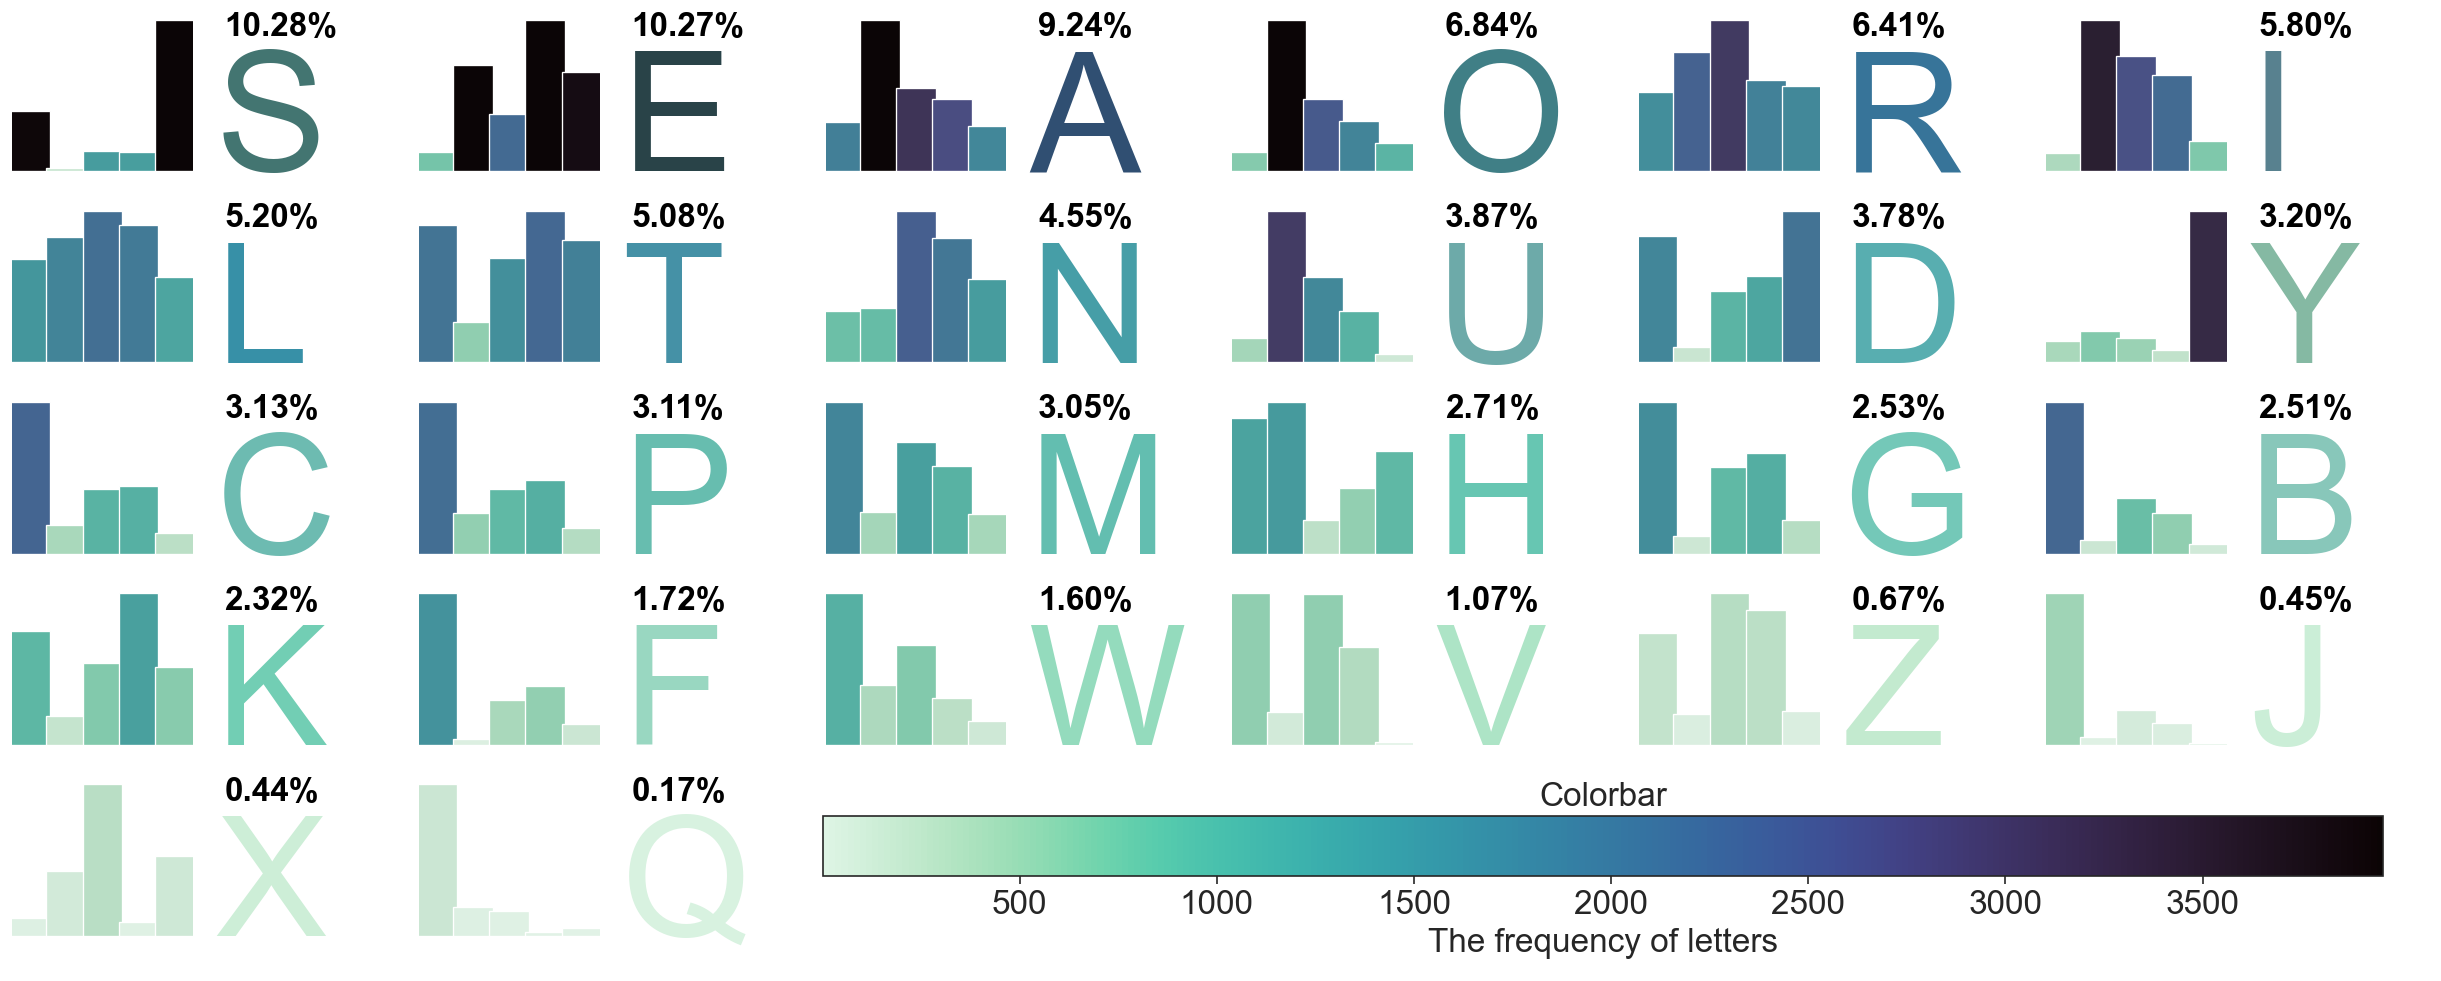

In [1333]:
fig = plt.figure(figsize=(26,10),dpi=120)
sns.set_style("white")
plt.subplots_adjust(hspace=0.2, wspace=0.5)
grids = GridSpec(5,36)
ticks = [1,2,3,4,5]
v_min, v_max = letters_freq.min().min(), letters_freq.max().max()
k = 0
for i in range(5):
    for j in range(6):
        ax = plt.subplot(grids[i,(6*(j+1)-6):(6*(j+1)-3)])
        let = letters_freq_sum.index[k]
        pcolor = [sns.cm.mako_r(2.5*(val - v_min) / v_max) for val in letters_freq.loc[let].values]
        sns.barplot(x=ticks,y=letters_freq.loc[let].values,ax=ax,width=1.1,
                    palette=pcolor)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['bottom'].set_color('none')

        # ax.set_title(let)
        ax = plt.subplot(grids[i,(6*(j+1)-3):(6*(j+1))])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        dist = 0.15
        dist_let = {"C": 0.15, "W": -0.05, "M": 0.05,"G": 0.10, "I": 0.5, "J": 0.3, "Q": 0.10, "Z": 0.20}
        if let in dist_let:
            dist = dist_let[let]
        ax.text(0,0,let,fontsize=100,color=np.mean(pcolor,axis=0))
        ax.text(0.05,0.85,"%.2f"%(100*letters_freq_sum[let]) + "%",fontsize=20,color="black",weight="bold")
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['bottom'].set_color('none')

        k += 1
        if k > 25:
            break
    if k > 25:
        break
cmap = sns.cm.mako_r
norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
position = fig.add_axes([0.385, 0.16, 0.5, 0.05])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=position, orientation='horizontal', label='spring')
cbar.ax.tick_params(labelsize=20) #设置colorbar刻度字体大小。
cbar.ax.set_title("Colorbar",fontdict={"fontsize": 20})
cbar.ax.set_xlabel("The frequency of letters",fontdict={"fontsize": 20})
# plt.tight_layout()

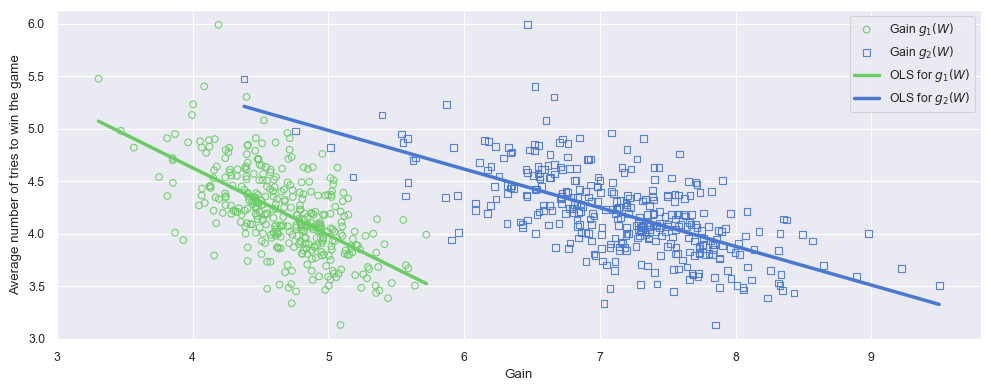

In [1322]:
sns.set_style("darkgrid")
sns.set_context("paper")
fig,ax = plt.subplots(figsize=(10,4))
ax.scatter(features["gain_1"],features["avg_tries"],color="none",edgecolor=colors[2],label="Gain $g_1(W)$",alpha=0.9,marker="o")
ax.scatter(features["gain_2"],features["avg_tries"],color="none",edgecolor=colors[0],label="Gain $g_2(W)$",alpha=0.9,marker="s")

x_min, x_max = features["gain_1"].min(), features["gain_1"].max()
x = np.linspace(x_min,x_max,100)
y = -0.64046042*x + 7.18892026
ax.plot(x,y,color=colors[2],label="OLS for $g_1(W)$",lw=2.5)

x_min, x_max = features["gain_2"].min(), features["gain_2"].max()
x = np.linspace(x_min,x_max,100)
y = -0.36824111*x + 6.82513687
ax.plot(x,y,color=colors[0],label="OLS for $g_2(W)$",lw=2.5)
""
ax.legend()
ax.set_xlabel("Gain")
ax.set_ylabel("Average number of tries to win the game")
plt.tight_layout()